In [1]:
# Libraries
import random
import numpy as np
from numba import njit
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 600

# Constants
random.seed(0)
tf = 60
dt = 0.01
N = round(tf/dt)
t = np.arange(0, tf, dt)

tspan = [0, tf]
c0 = [0, 0]

# Function definitions
@njit
def system(x, y, k1, k2, k3, k4, Ac, xi):
    """
    This function returns the ODE system.

    Args:
        z (list): state variables
        k1 (float): k1 constant
        k2 (float): k2 constant
        k3 (float): k3 constant
        k4 (float): k4 constant
        Ac (float): Ac constant
        xi (float): xi constant
    
    Returns:
        list: ODE system
    """
    return np.array([- k1*x - k2*y + Ac, k3*x - k4*y + xi*Ac])

@njit
def rk4(equations, tf, dt, c0, k1, k2, k3, k4, Ac, xi):
    """
    This function implements the Runge-Kutta 3 method for a system of ODEs.

    Args:
        equations (function): The system of ODEs
        tf (float): Final time
        dt (float): The time step
        c0 (array): Initial conditions

    Returns:
        list: Solution of the system of ODEs
    """
    N = round(tf/dt)
    sol = np.empty((N, len(c0)))
    sol[0] = np.array(c0)
    
    for i in range(N-1):
        K1 = equations(sol[i][0], sol[i][1], k1, k2, k3, k4, Ac, xi)
        K2 = equations(sol[i][0] + 0.5*dt, sol[i][1] + 0.5*dt*K1[1], k1, k2, k3, k4, Ac, xi)
        K3 = equations(sol[i][0] + 0.5*dt, sol[i][1] + 0.5*dt*K2[1], k1, k2, k3, k4, Ac, xi)
        K4 = equations(sol[i][0] + dt, sol[i][1] + dt*K3[1], k1, k2, k3, k4, Ac, xi)
        sol[i+1] = sol[i] + dt*(K1 + 2*K2 + 2*K3 + K4)/6
    return sol

# NFBL

In [2]:
# xi = 0

# Initial curve parameters
k1, k2, k3, k4, Ac, xi = 1, 2, 0.05, 0.05, 1, 0

B = k1 + k4
C = k1*k4 + k2*k3
Q = k4

# k4 has to be fixed as 1, therefor k1 also has to be fixed as 1
total_curves = 50000
num_curves = int(total_curves/2)
k2_vals = np.random.uniform(0, 3, num_curves)
k3_vals = (C - k1*k4)/k2_vals

In [3]:
# Solve the system for each pair of k2 and k3
t_shape = np.shape(t)[0]

x = np.empty([num_curves, t_shape])
y = np.empty([num_curves, t_shape])

for i in tqdm(range(num_curves)):
    sol = rk4(system, tf, dt, c0, k1, k2_vals[i], k3_vals[i], k4, Ac, xi)
    x[i] = sol[:, 0]
    y[i] = sol[:, 1]

100%|██████████| 25000/25000 [00:32<00:00, 762.51it/s]


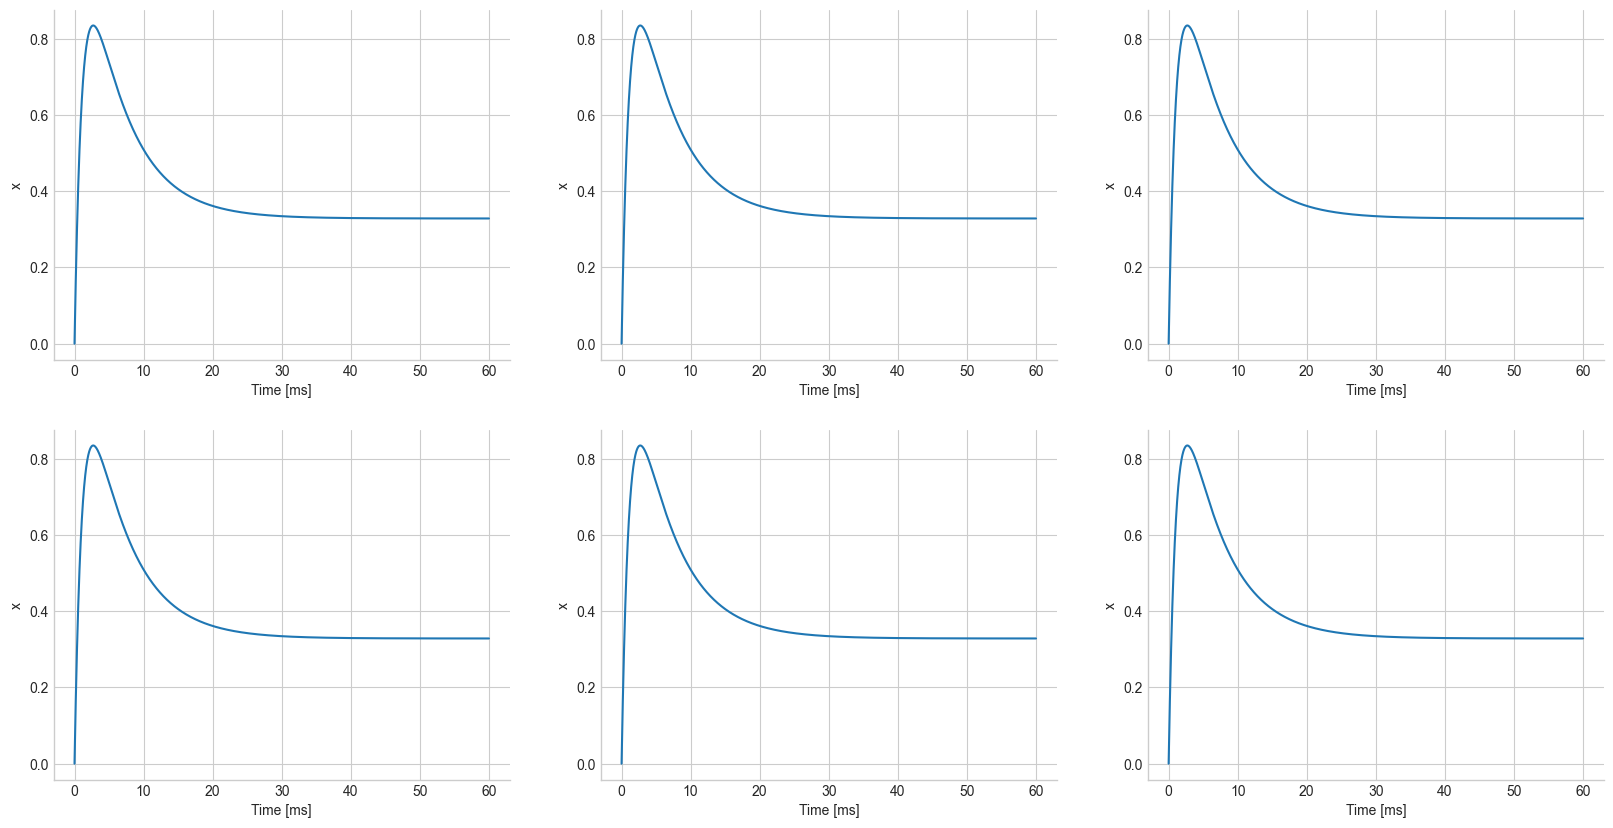

In [4]:
# Plot X
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i in range(6):
    ax[i//3, i%3].plot(t, x[i])
    ax[i//3, i%3].set_xlabel('Time [ms]')
    ax[i//3, i%3].set_ylabel('x')

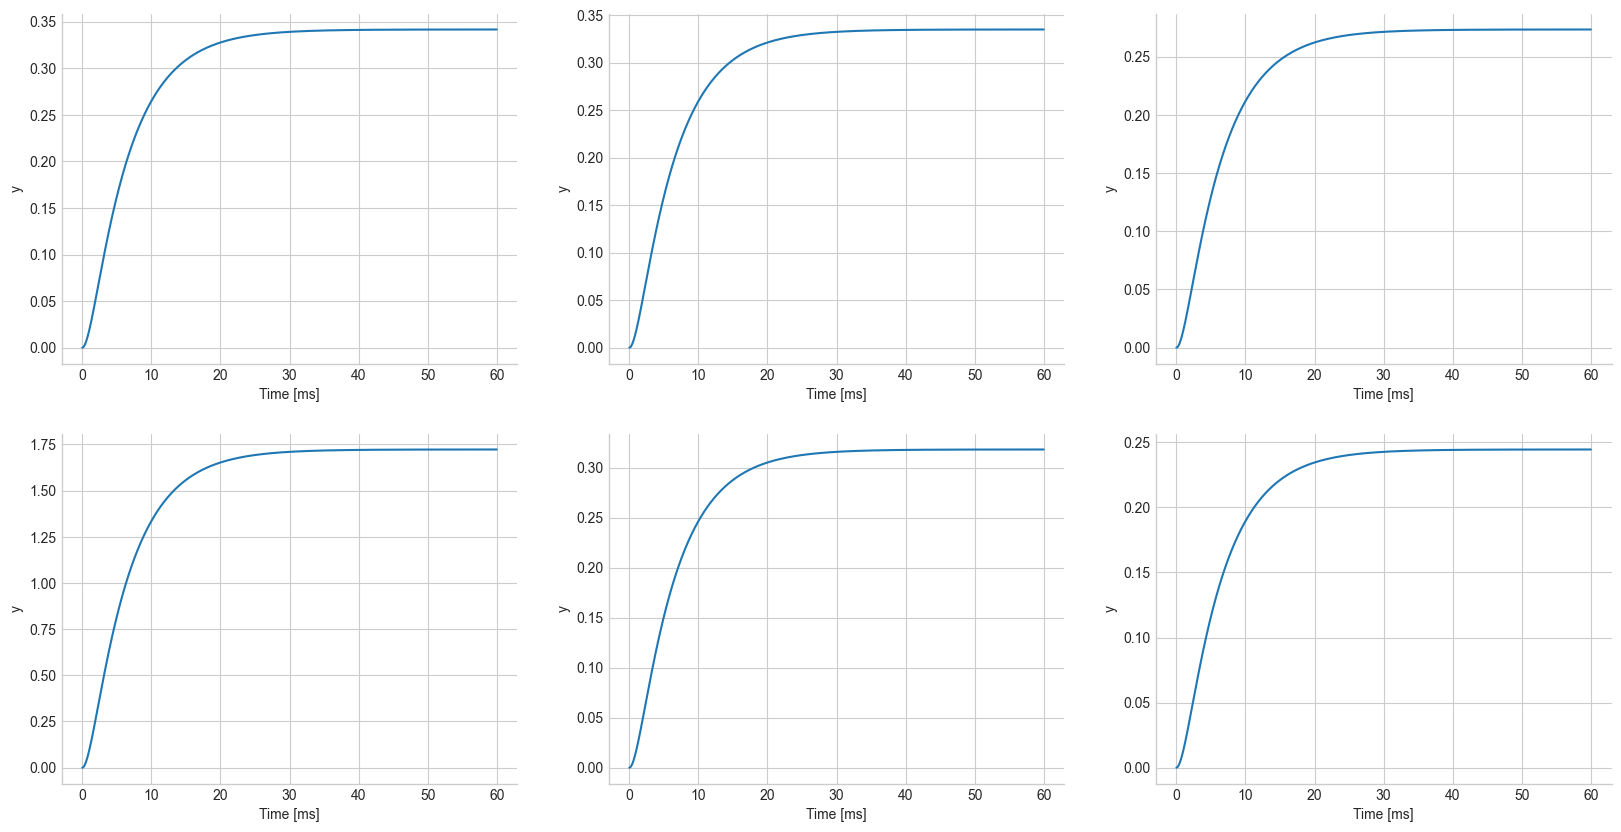

In [5]:
# Plot Y
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i in range(6):
    ax[i//3, i%3].plot(t, y[i])
    ax[i//3, i%3].set_xlabel('Time [ms]')
    ax[i//3, i%3].set_ylabel('y')

In [6]:
t_min = 10
t_max = 50
t_vals = np.random.randint(t_min, t_max, num_curves)

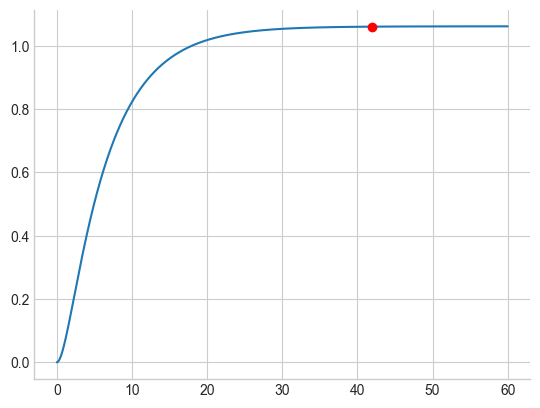

In [7]:
t_correction = int(1/dt)

plt.plot(t, y[10])
plt.plot(t_vals[10], y[10][t_vals[10]*t_correction], 'ro')

In [8]:
data = np.empty([num_curves*2, tf+2]) # +2 since we need to add t and y(t)
indices = np.arange(tf) * t_correction

for i in range(num_curves):
    data[i, 0] = t_vals[i]
    data[i, 1] = y[i][t_vals[i]*t_correction]
    data[i, 2:] = x[i][indices]

# IFFL

In [9]:
# K3 = 0

# B = 1.05
# C = 0.15
# Q = 0.05

# Initial curve parameters
K4 = (-B + np.sqrt(B**2 - 4*C)) / (-2)
K1 = B - K4
K3 = 0

B = K1 + K4 # -> K1 = B-K4 -> K1 = 0.8794361719689456
C = K1*K4 # -> K4*(B-K4) = C -> 0 = -K4^2 + B*K4 - C -> K4 = 0.1705638280310544
Q = 0.05

# K1 and K4 have to be fixed to their respective values
K2_vals = np.random.uniform(0, 3, num_curves)
xi_vals = (K4-Q)/K2_vals

print(f"K1: {K1}, K4: {K4}, B: {B}, C: {C}, Q: {Q}.")

K1: 0.8794361719689456, K4: 0.1705638280310544, B: 1.05, C: 0.15000000000000002, Q: 0.05.


In [10]:
# Solve the system for each pair of K2 and xi
x = np.empty([num_curves, t_shape])
y = np.empty([num_curves, t_shape])

for i in tqdm(range(num_curves)):
    sol = rk4(system, tf, dt, c0, K1, K2_vals[i], K3, K4, Ac, xi_vals[i])
    x[i] = sol[:, 0]
    y[i] = sol[:, 1]

100%|██████████| 25000/25000 [00:31<00:00, 791.90it/s]


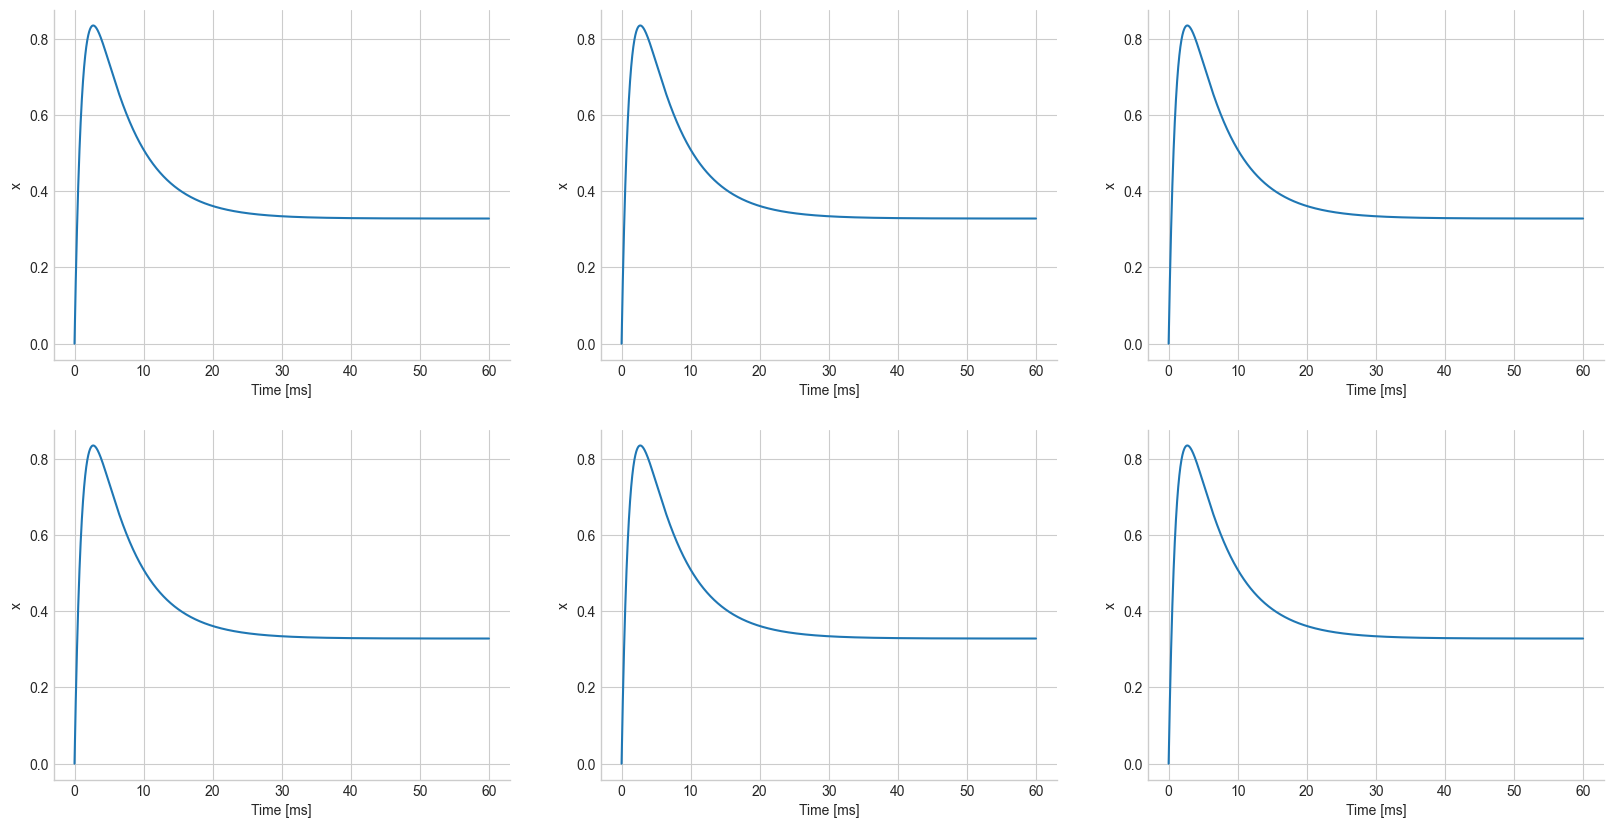

In [11]:
# Plot X
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i in range(6):
    ax[i//3, i%3].plot(t, x[i])
    ax[i//3, i%3].set_xlabel('Time [ms]')
    ax[i//3, i%3].set_ylabel('x')

In [12]:
for i in range(num_curves):
    data[num_curves+i, 0] = t_vals[i]
    data[num_curves+i, 1] = y[i][t_vals[i]*t_correction]
    data[num_curves+i, 2:] = x[i][indices]

In [13]:
# Create the labels array
# 1 NFBL, 0 IFFL
labels = np.empty(total_curves)
labels[:num_curves] = 1
labels[num_curves:] = 0

In [14]:
# Save the data
np.savetxt("data_RK4_same_Xcurve.csv", data, delimiter=",")
np.savetxt("labels.csv", labels, delimiter=",")